<a href="https://colab.research.google.com/github/EVELYNLUCCA/Alura_Challenge_Robot_Trading/blob/main/Challenge_Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Configuración del ambiente

In [1]:
# Declaración de Variables globales:

global df_bitcoin
global precio_actual
global tendencia
global media_bitcoin
global algoritmo_decision

In [2]:
# Verificación de versiones de librerías:

!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'
print('------')
! pip install yfinance

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1
------


In [3]:
# Importación de librerías necesarias:

# Pandas:
import pandas as pd

# Api de finanzas:
import yfinance as yf

# Para web scraping:
from bs4 import BeautifulSoup
import requests

# Para gráficos:
%matplotlib inline
import matplotlib.pyplot as plt

# Time:
from IPython.display import clear_output
import time

# 2. Obtención de datos

In [4]:
def importar_base_bitcoin():

  global df_bitcoin

  bitcoin = yf.Ticker('BTC-USD')
  df_bitcoin = bitcoin.history(period='7d', interval='5m')

  return df_bitcoin

In [5]:
def extraer_tendencias():

    global precio_actual
    global tendencia

    headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36'}
    url = 'https://coinmarketcap.com/'
    respuesta = requests.get(url, headers = headers)

    s = BeautifulSoup(respuesta.content, features ="lxml")
    precio = s.find('a', {'href': '/currencies/bitcoin/#markets'})
    precio_actual = precio.text
    precio_actual = precio_actual.replace(',', '')
    precio_actual = float(precio_actual.replace('$', ''))
    tendencia = s.find('span', {'class':'sc-d55c02b-0'})
    tendencia_color = tendencia['class'][1]

    clases = tendencia.span['class']

# Tendencia baja: icon-Caret-down => negativo
# Tendencia alta: icon-Caret-up => positivo

    if (tendencia_color == 'gUnzUB' and clases == ['icon-Caret-down']):
        tendencia = 'baja'
    elif (tendencia_color == 'iwhBxy' and clases == ['icon-Caret-up']):
        tendencia = 'alta'
    return precio_actual, tendencia

In [6]:
importar_base_bitcoin()
df_bitcoin_limpio = df_bitcoin.copy()

# 3. Limpieza de datos

In [7]:
duplicados = df_bitcoin_limpio.index.duplicated()

# Conclusión: NO hay valores duplicados en el índice Datatime, pero igualmente implemento el método drop_duplicates() por seguridad:

df_bitcoin_limpio.drop_duplicates(inplace = True)

In [8]:
df_bitcoin_limpio['Close'].info()

# Conclusión: NO hay valores nulos en la columna Close, pero igualmente implemento método dropna() por seguridad:
df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset = ['Close'])

<class 'pandas.core.series.Series'>
DatetimeIndex: 1863 entries, 2023-10-26 00:00:00+00:00 to 2023-11-01 11:10:00+00:00
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1863 non-null   float64
dtypes: float64(1)
memory usage: 29.1 KB


In [9]:
df_bitcoin_limpio['Volume']

Datetime
2023-10-26 00:00:00+00:00          0
2023-10-26 00:05:00+00:00          0
2023-10-26 00:10:00+00:00     317440
2023-10-26 00:15:00+00:00          0
2023-10-26 00:20:00+00:00          0
                              ...   
2023-11-01 10:50:00+00:00    4631552
2023-11-01 10:55:00+00:00    7808000
2023-11-01 11:00:00+00:00          0
2023-11-01 11:05:00+00:00          0
2023-11-01 11:10:00+00:00     579584
Name: Volume, Length: 1863, dtype: int64

In [10]:
df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] != 0]

# Conclusión: ya NO hay registros con volumen de transacción iguales a cero.


In [11]:
def limpieza_datos():

    global media_bitcoin

    df_bitcoin_limpio = importar_base_bitcoin()

    #duplicados = df_bitcoin_limpio.index.duplicated()
    #df_bitcoin_limpio['Close'].info()
    df_bitcoin_limpio.drop_duplicates(inplace = True)
    df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset = ['Close'])
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] != 0]

    # fig, eje = plt.subplots(2, 1, figsize=(8, 10)) # Config de 2 gráficos
    # fig, ejes = plt.subplots(2, 1, figsize=(8, 10)) # Config de 2 gráficos

    # eje[0].boxplot(df_bitcoin_limpio['Close'])
    # eje[0].set_title('Boxplot de la Base Original')
    # eje[0].set_ylabel('Valores al cierre')


    # ejes[0].hist(df_bitcoin['Close'])
    # ejes[0].set_xlabel('Valores al cierre')
    # ejes[0].set_ylabel('Frecuencia de Valores')
    # ejes[0].set_title('Histograma de la Base Original')

    close = df_bitcoin_limpio['Close']
    Q1 = close.quantile(0.25) # Primer cuartil
    Q3 = close.quantile(0.75) # Tercer cuartil

    seleccion = (close >= Q1) & (close <= Q3)
    new_df_bitcoin = df_bitcoin_limpio[seleccion]

    # eje[1].boxplot(new_df_bitcoin['Close'])
    # eje[1].set_title('Boxplot de la Base Limpia')
    # eje[1].set_ylabel('Valores al cierre')

    # ejes[1].hist(df_bitcoin_limpio['Close'])
    # ejes[1].set_xlabel('Valores al cierre')
    # ejes[1].set_ylabel('Frecuencia de Valores')
    # ejes[1].set_title('Histograma de la Base Limpia')

    # plt.tight_layout()
    # plt.show()  # Muestra los gráficos

    media_bitcoin = (new_df_bitcoin['Close'].mean()).round(2)

    return media_bitcoin

# 4. Tomar decisiones

In [12]:
def tomar_decisiones():
    global algoritmo_decision
    global tendencia
    global media_bitcoin
    global precio_actual

    if precio_actual >= media_bitcoin and tendencia == 'baja':
        algoritmo_decision = 'Vender'
    elif precio_actual < media_bitcoin and tendencia == 'alta':
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'

#print('Precio Actual Bitcoin: $USD', precio_actual)
#print('Precio Promedio Bitcoin: $USD', media_bitcoin)
#print('Tendencia:', tendencia)
#print('Decisión del algoritmo:', algoritmo_decision)

# 5. Visualización

In [13]:
def visualizacion():

  global df_bitcoin
  global media_bitcoin
  global algoritmo_decision

  df_bitcoin['Promedio'] = media_bitcoin
  plt.figure(figsize=(16, 5))
  plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precios de Cierre')
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], color='red', label = 'Precio Promedio')
  plt.title('Fluctuación de los Precios de Cierre del Bitcoin durante 7 días')
  plt.xlabel('Fechas')
  plt.ylabel('Precios de Cierre')
  plt.grid(True)
  plt.annotate(f'Decisión: {algoritmo_decision}',
               xy=(df_bitcoin.index[0],
               df_bitcoin.Close[0]),
               xytext=(df_bitcoin.index[0],
               df_bitcoin.Close[-1]),fontsize = 14)
  plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

  plt.show()

# 6. Automatización

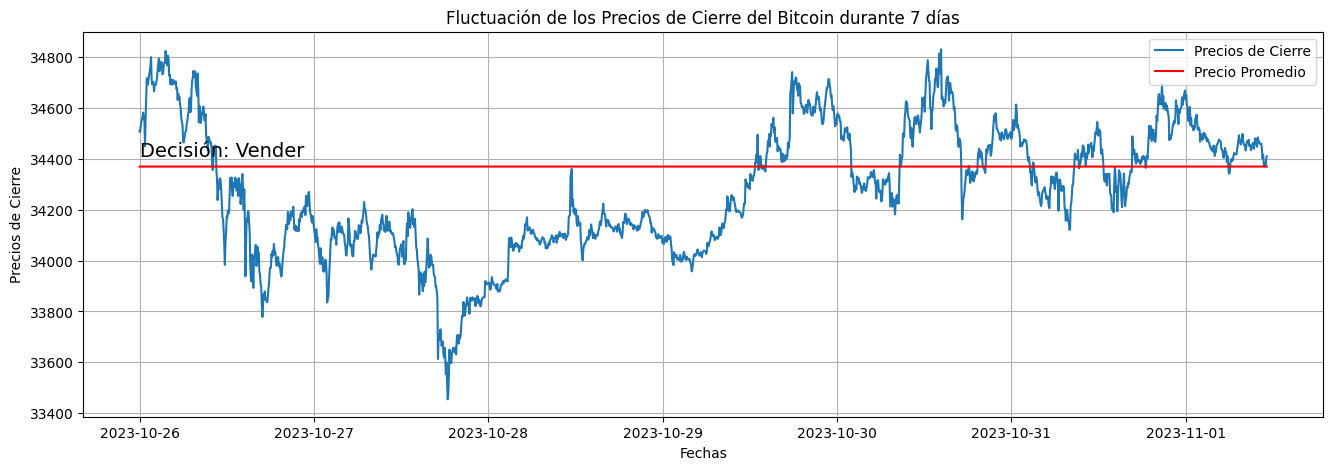

KeyboardInterrupt: ignored

In [14]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)  # El gráfico se actualiza cada 5 minutos
